<a href="https://colab.research.google.com/github/JordanFoss/STAT3007_Project/blob/main/CNN_LSTM_Training_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading all the needed things


In [26]:
!git clone https://github.com/JordanFoss/STAT3007_Project.git
%cd STAT3007_Project/

Cloning into 'STAT3007_Project'...
remote: Enumerating objects: 4295, done.
remote: Counting objects: 100% (573/573), done.
remote: Compressing objects: 100% (356/356), done.
remote: Total 4295 (delta 214), reused 573 (delta 214), pack-reused 3722
Receiving objects: 100% (4295/4295), 973.20 MiB | 16.02 MiB/s, done.
Resolving deltas: 100% (799/799), done.
Checking out files: 100% (2956/2956), done.
/content/STAT3007_Project/STAT3007_Project/STAT3007_Project/STAT3007_Project


In [27]:
!pip install colorednoise as cn

In [28]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
import scipy
import numpy as np
import librosa
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.autograd import Variable
import pandas as pd
import glob
import os
from librosa import display
from torchsummary import summary
import sklearn

from IPython.display import Audio

# load our own python files
from pre_process import *
from data_loading import *
from Models import *
from Model_Functions import *

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load Clean Data (from github repo)

In [30]:
# loads all clean samples
X,y = load_samples(os.getcwd())
X = torch.tensor(X)
X = X.reshape(X.shape[0],1,X.shape[1],X.shape[2])
y = torch.tensor(y)

# train/test split and make into datasets
data_sets = load_sets(X,y,train_ratio=[0.8], seed = [10])
data_train, data_test = data_sets[0]

## Load Noisy data (from google drive)

In [31]:
#Import all the splited noisy data
noisy_data_train = np.load('/content/drive/MyDrive/STAT3007_project/train_test_split_snr40/noisy_train_snr40.npy')
noisy_data_test = np.load('/content/drive/MyDrive/STAT3007_project/train_test_split_snr40/noisy_test_snr40.npy')
noisy_targets_train = np.load('/content/drive/MyDrive/STAT3007_project/train_test_split_snr40/target_train_snr40.npy')
noisy_targets_test = np.load('/content/drive/MyDrive/STAT3007_project/train_test_split_snr40/target_test_snr40.npy')

# reformat
noisy_data_train = noisy_data_train.reshape(noisy_data_train.shape[0],1,noisy_data_train.shape[1],noisy_data_train.shape[2])
noisy_data_test = noisy_data_test.reshape(noisy_data_test.shape[0],1,noisy_data_test.shape[1],noisy_data_test.shape[2])
noisy_data_train = torch.tensor(noisy_data_train)
noisy_data_test = torch.tensor(noisy_data_test)

noisy_targets_train = torch.tensor(noisy_targets_train)
noisy_targets_test = torch.tensor(noisy_targets_test)

# make into datasets
noisy_train = DatasetWrapper(noisy_data_train,noisy_targets_train)
noisy_test = DatasetWrapper(noisy_data_test,noisy_targets_test)

# Training

In [32]:
def train_model(data_train, 
                data_test, 
                net, loss, 
                nepoch , 
                lr = 0.01, 
                batch_size = -1, 
                momentum = 0,
                use_cuda = False, 
                print_output = True, 
                optimiser = 'SGD'):

  # setting up arrays for recording
  test_acc = []
  avg_acc = []
  test_loss = []
  avg_loss = []

  # appropriate data type for CPU or GPU
  device = None
  if use_cuda and torch.cuda.is_available():
    dtype = torch.cuda.FloatTensor
    device = torch.device("cuda")
    net = net.to(device)
  else:
    dtype = torch.FloatTensor

  # choice of optimiser
  if optimiser == 'SGD':
    optimizer = optim.SGD(net.parameters(), lr = lr, momentum = momentum)
  else:
    optimizer = optim.Adam(net.parameters(), lr = lr, momentum = momentum)

  
  data_train = data_train.change_type(dtype)
  data_test = data_test.change_type(dtype)


  X_test,y_test = data_test.get_data()

  # for entropy loss
  y_test = y_test.type(torch.LongTensor)
  if device != None:
    y_test = y_test.type(torch.cuda.LongTensor)

  data_loader = DataLoader(data_train, batch_size = batch_size, shuffle = True)

  for epoch in range(nepoch):
    batch_acc = []
    batch_loss = []
    for X_batch, y_batch in data_loader:
      
      # change data type
      y_batch = y_batch.type(torch.LongTensor)
      if use_cuda and device != None:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        y_batch = y_batch.type(torch.cuda.LongTensor)

      optimizer.zero_grad()

      pred = net(X_batch, use_cuda = use_cuda)
      Rn = loss(pred, y_batch)
      accur = accuracy(pred,y_batch)

      batch_acc.append(accur)
      batch_loss.append(Rn.to(torch.device('cpu')).detach().numpy())

      Rn.backward()
      optimizer.step()

    # average batch status
    avg_batch_loss = np.mean(batch_loss)
    avg_batch_acc = np.mean(batch_acc)

    avg_acc.append(avg_batch_acc)
    avg_loss.append(avg_batch_loss)

    # test results in current epoch
    pred = net(X_test, use_cuda = use_cuda)
    Rn = loss(pred, y_test)
    accur = accuracy(pred,y_test)
    test_acc.append(accur)
    test_loss.append(Rn.to(torch.device('cpu')).detach().numpy())


    if print_output:
      print('epoch:', epoch)
      print('loss:',Rn.item())
      print('------------')
    

  print('final loss:', Rn.item())

  return net, avg_loss, avg_acc, test_loss, test_acc

## Clean data train/test
* random seed = 69
* Optimiser: SGD
* lr: 0.01
* epoch number: 40 
* momentum: 0.2

In [33]:
# optimal hyperparameters:
nepoch = 50
lr = 0.01
momentum = 0.2
optimiser = 'SGD'
loss = nn.CrossEntropyLoss()

# initialise model
torch.manual_seed(69)
CNN = ConvNet()
conv_LSTM = LRCN(CNN)

# train model
trained_net,avg_loss, avg_acc, test_loss, test_acc = train_model(data_train, data_test, conv_LSTM, loss, nepoch=nepoch, momentum = momentum ,batch_size = 10,lr = lr, use_cuda = True, print_output = False, optimiser = optimiser)

final loss: 0.8291003108024597


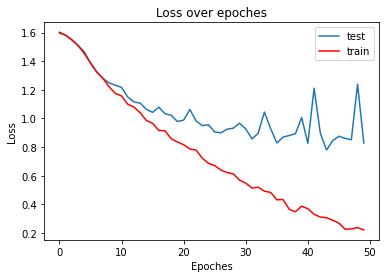

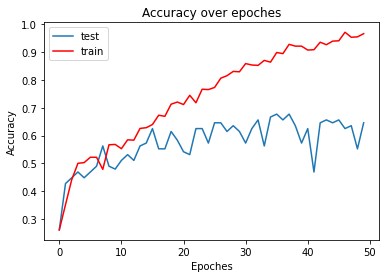

In [34]:
# test results
X_test,y_test = data_test.get_data()
trained_net = trained_net.to(torch.device('cpu'))
pred = trained_net(X_test)
y_pred = classification(pred)


epoches = [i for i in range(nepoch)]

fig = plt.figure()
plt.plot(epoches,test_loss, label = 'test')
plt.plot(epoches,avg_loss, label = 'train', color = 'r')
plt.title('Loss over epoches')
plt.xlabel('Epoches')
plt.ylabel('Loss')
plt.legend()

fig = plt.figure()
plt.plot(epoches,test_acc, label = 'test')
plt.plot(epoches,avg_acc, label = 'train', color = 'r')
plt.title('Accuracy over epoches')
plt.xlabel('Epoches')
plt.ylabel('Accuracy')
plt.legend()

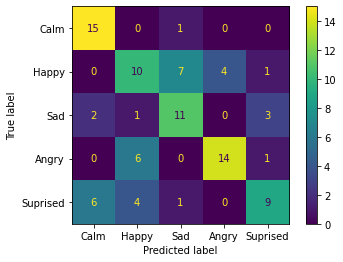

In [35]:

labels = ['Calm', 'Happy', 'Sad', 'Angry', 'Suprised']
confusion = sklearn.metrics.confusion_matrix(y_test.detach().numpy(), y_pred)
thing = sklearn.metrics.ConfusionMatrixDisplay(confusion, display_labels=labels)
thing.plot()

## Noisy train/test
* random seed = 69
* Optimiser: SGD
* lr: 0.01
* epoch number: 40 
* momentum: 0.2

In [36]:
# hyperparameters:
nepoch = 50
lr = 0.01
momentum = 0.2
optimiser = 'SGD'
loss = nn.CrossEntropyLoss()

torch.manual_seed(69)
CNN = ConvNet()
conv_LSTM = LRCN(CNN)
trained_net,avg_loss, avg_acc, test_loss, test_acc = train_model(noisy_train, noisy_test, conv_LSTM, loss, nepoch=nepoch, momentum = momentum ,batch_size = 10,lr = lr, use_cuda = True, print_output = False, optimiser = optimiser)

final loss: 2.5369949340820312


In [37]:
X_test,y_test = noisy_test.get_data()
trained_net = trained_net.to(torch.device('cpu'))
pred = trained_net(X_test)
y_pred = classification(pred)

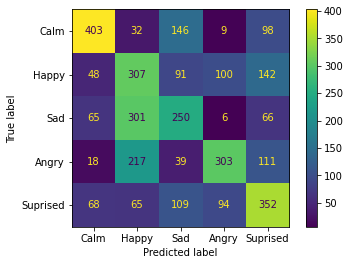

In [38]:
import sklearn
labels = ['Calm', 'Happy', 'Sad', 'Angry', 'Suprised']
confusion = sklearn.metrics.confusion_matrix(y_test.detach().numpy(), y_pred)
thing = sklearn.metrics.ConfusionMatrixDisplay(confusion, display_labels=labels)
thing.plot(values_format = '.5g')

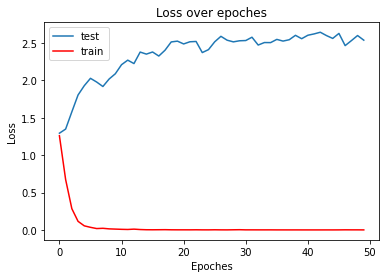

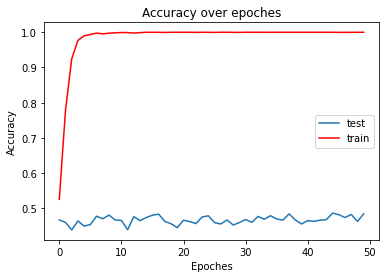

In [39]:
epoches = [i for i in range(nepoch)]

fig = plt.figure()
plt.plot(epoches,test_loss, label = 'test')
plt.plot(epoches,avg_loss, label = 'train', color = 'r')
plt.title('Loss over epoches')
plt.xlabel('Epoches')
plt.ylabel('Loss')
plt.legend()

fig = plt.figure()
plt.plot(epoches,test_acc, label = 'test')
plt.plot(epoches,avg_acc, label = 'train', color = 'r')
plt.title('Accuracy over epoches')
plt.xlabel('Epoches')
plt.ylabel('Accuracy')
plt.legend()